In [1]:
# Imports
#!pip install matplotlib numpy pandas seaborn jax jaxlib dm-haiku tensorflow exmol
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


import exmol
import tensorflow as tf
import seaborn as sns
import jax.numpy as jnp
import jax
import jax.experimental.optimizers as opt
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import haiku as hk
import numpy as np
import rdkit, rdkit.Chem, rdkit.Chem.rdDepictor, rdkit.Chem.Draw
import mordred, mordred.descriptors
import sklearn.metrics
from IPython.display import display, SVG
from rdkit.Chem.Draw import MolToImage as mol2img, DrawMorganBit  # type: ignore
from rdkit.Chem import rdchem, MACCSkeys, AllChem  # type: ignore

import warnings

warnings.filterwarnings("ignore")
sns.set_context("notebook")
sns.set_style(
    "dark",
    {
        "xtick.bottom": True,
        "ytick.left": True,
        "xtick.color": "#666666",
        "ytick.color": "#666666",
        "axes.edgecolor": "#666666",
        "axes.linewidth": 0.8,
        "figure.dpi": 300,
    },
)
color_cycle = ["#1BBC9B", "#F06060", "#5C4B51", "#F3B562", "#6e5687"]
mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=color_cycle)
mpl.rcParams["font.size"] = 10
np.random.seed(0)
tf.random.set_seed(0)

### GNN Model Related Code

GNN model using molecular scent dataset from Leffingwell Odor Datset (https://zenodo.org/record/4085098#.YTfYwy1h29Y)

Code below modified from example code given in the "Predicting DFT Energies with GNNs" and "Interpretability and Deep Learning" sections of "Deep Learning for Molecules and Materials" textbook (https://whitead.github.io/dmol-book/applied/QM9.html)

In [2]:
# Parameters for GNN model
node_feat_length = 256
message_feat_length = 256
graph_feat_length = 512
weights_stddevGNN = 0.01


# Code to load data & generate graphs + labels for all molecules in dataset
# Load data --> file uploaded to jhub (locally stored)
scentdata = pd.read_csv("leffingwell_data_shuffled.csv")

# Code to generate list of all scent labels (scentClasses)
numMolecules = len(scentdata.odor_labels_filtered)
numClasses = 112  # No odorless class
scentClasses = []
moleculeScentList = []
for i in range(numMolecules):
    scentString = scentdata.odor_labels_filtered[i]
    temp = scentString.replace("[", "")
    temp = temp.replace("]", "")
    temp = temp.replace("'", "")
    temp = temp.replace(" ", "")
    scentList = temp.split(",")
    if "odorless" in scentList:
        scentList.remove("odorless")
    moleculeScentList.append(scentList)
    for j in range(len(scentList)):
        if not (scentList[j] in scentClasses):
            scentClasses.append(scentList[j])

# Check to make sure read in data properly & created scentClasses & moleculeScentList correctly
print(f"Is the number of scent classes 112?: {len(scentClasses)==112}")
print(f"Is the number of molecules 3523?: {len(moleculeScentList)==3523}")


def gen_smiles2graph(sml):
    """Argument for the RD2NX function should be a valid SMILES sequence
    returns: the graph
    """
    m = rdkit.Chem.MolFromSmiles(sml)
    m = rdkit.Chem.AddHs(m)
    order_string = {
        rdkit.Chem.rdchem.BondType.SINGLE: 1,
        rdkit.Chem.rdchem.BondType.DOUBLE: 2,
        rdkit.Chem.rdchem.BondType.TRIPLE: 3,
        rdkit.Chem.rdchem.BondType.AROMATIC: 4,
    }
    N = len(list(m.GetAtoms()))
    nodes = np.zeros((N, node_feat_length))
    for i in m.GetAtoms():
        nodes[i.GetIdx(), i.GetAtomicNum()] = 1
        # Add in whether atom is in a ring or not for one-hot encoding
        if i.IsInRing():
            nodes[i.GetIdx(), -1] = 1

    adj = np.zeros((N, N))
    for j in m.GetBonds():
        u = min(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        v = max(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        order = j.GetBondType()
        if order in order_string:
            order = order_string[order]
        else:
            raise Warning("Ignoring bond order" + order)
        adj[u, v] = 1
        adj[v, u] = 1
    adj += np.eye(N)
    return nodes, adj


# Function that creates label vector given list of strings describing scent of molecule as input
# Each index in label vector corresponds to specific scent -> if output has a 0 at index i, then molecule does not have scent i
# If label vector has 1 at index i, then molecule does have scent i


def createLabelVector(scentsList):
    # Find class index in label vector that each scent corresponds to & update label for that molecule to 1
    labelVector = np.zeros(numClasses)
    for j in range(len(scentsList)):
        # Find class index
        classIndex = scentClasses.index(scentsList[j])
        # print(classIndex)
        # print(scentsList[j])
        # print(scentClasses[classIndex])
        # Update label vector
        labelVector[classIndex] = 1
    return labelVector


def generateGraphs():
    for i in range(numMolecules):
        graph = gen_smiles2graph(scentdata.smiles[i])
        labels = createLabelVector(moleculeScentList[i])
        yield graph, labels


# Check that generateGraphs() works for 1st molecule
# print(gen_smiles2graph(scentdata.SMILES[0]))
# print(scentdata.SENTENCE[0].split(','))
# print(np.nonzero(createLabelVector(scentdata.SENTENCE[0].split(','))))
# print(scentClasses[89])
data = tf.data.Dataset.from_generator(
    generateGraphs,
    output_types=((tf.float32, tf.float32), tf.float32),
    output_shapes=(
        (tf.TensorShape([None, node_feat_length]), tf.TensorShape([None, None])),
        tf.TensorShape([None]),
    ),
)

Is the number of scent classes 112?: True
Is the number of molecules 3523?: True


In [3]:
class GNNLayer(
    hk.Module
):  # TODO: If increase number of layers, stack features & new_features and shrink via dense layer
    def __init__(self, output_size, name=None):
        super().__init__(name=name)
        self.output_size = output_size

    def __call__(self, inputs):
        # split input into nodes, edges & features
        nodes, edges, features = inputs
        # Nodes is of shape (N, Nf) --> N = # atoms, Nf = node_feature_length
        # Edges is of shape (N,N) (adjacency matrix)
        # Features is of shape (Gf) --> Gf = graph_feature_length

        graph_feature_len = features.shape[-1]  # graph_feature_len (Gf)
        node_feature_len = nodes.shape[-1]  # node_feature_len (Nf)
        message_feature_len = message_feat_length  # message_feature_length (Mf)

        # Initialize weights
        w_init = hk.initializers.RandomNormal(stddev=weights_stddevGNN)

        # we is of shape (Nf,Mf)
        we = hk.get_parameter(
            "we", shape=[node_feature_len, message_feature_len], init=w_init
        )

        # b is of shape (Mf)
        b = hk.get_parameter("b", shape=[message_feature_len], init=w_init)

        # wv is of shape (Mf,Nf)
        wv = hk.get_parameter(
            "wv", shape=[message_feature_len, node_feature_len], init=w_init
        )

        # wu is of shape (Nf,Gf)
        wu = hk.get_parameter(
            "wu", shape=[node_feature_len, graph_feature_len], init=w_init
        )

        # make nodes be N x N x Nf so we can just multiply directly (N = number of atoms)
        # ek is now shaped N x N x Mf
        ek = jax.nn.leaky_relu(
            b
            + jnp.repeat(nodes[jnp.newaxis, ...], nodes.shape[0], axis=0)
            @ we
            * edges[..., None]
        )

        # Uncomment lines below to update edges
        # Update edges, use jnp.any to have new_edges be of shape N x N
        # new_edges = jnp.any(ek, axis=-1)

        # Normalize over edge features w/layer normalization
        # new_edges = hk.LayerNorm(axis=[0,1], create_scale=False, create_offset=False, eps=1e-05)(new_edges)

        # take sum over neighbors to get ebar shape = Nf x Mf
        ebar = jnp.sum(ek, axis=1)

        # dense layer for new nodes to get new_nodes shape = N x Nf
        new_nodes = jax.nn.leaky_relu(ebar @ wv) + nodes  # Use leaky ReLU

        # Normalize over node features w/layer normalization
        new_nodes = hk.LayerNorm(
            axis=[0, 1], create_scale=False, create_offset=False, eps=1e-05
        )(new_nodes)

        # sum over nodes to get shape features so global_node_features shape = Nf
        global_node_features = jnp.sum(new_nodes, axis=0)

        # dense layer for new features so new_features shape = Gf
        new_features = (
            jax.nn.leaky_relu(global_node_features @ wu) + features
        )  # Use leaky ReLU for activation

        return new_nodes, edges, new_features


def model_fn(x):
    nodes, edges = x
    features = jnp.ones(graph_feat_length)
    x = nodes, edges, features

    # NOTE: If edited config.num_GNN_layers, need to edit code below (increase or decrease # times have x = GNNLayer(...))
    # 4 GNN layers
    x = GNNLayer(output_size=graph_feat_length)(x)
    x = GNNLayer(output_size=graph_feat_length)(x)
    x = GNNLayer(output_size=graph_feat_length)(x)
    x = GNNLayer(output_size=graph_feat_length)(x)

    # 2 dense layers
    logits = hk.Linear(numClasses)(x[-1])
    # logits = jax.nn.relu(logits) #ReLU activation between dense layer
    logits = hk.Linear(numClasses)(logits)

    return logits  # Model now returns logits


model = hk.without_apply_rng(hk.transform(model_fn))

# Initialize model
rng = jax.random.PRNGKey(0)
sampleData = data.take(1)
for dataVal in sampleData:  # Look into later how to get larger set
    (nodes_i, edges_i), yi = dataVal
nodes_i = nodes_i.numpy()
edges_i = edges_i.numpy()

yi = yi.numpy()
xi = (nodes_i, edges_i)

params = model.init(rng, xi)

In [4]:
# Load optimal parameters for GNN model
print("Edit fileName to change parameters being loaded")
fileName = "optParams_dry-waterfall-17.npy"  # Currently optimal parameters, edit when get better model
paramsArr = jnp.load(fileName, allow_pickle=True)
opt_params = {
    "gnn_layer": {
        "b": paramsArr[0],
        "we": paramsArr[1],
        "wu": paramsArr[2],
        "wv": paramsArr[3],
    },
    "gnn_layer_1": {
        "b": paramsArr[4],
        "we": paramsArr[5],
        "wu": paramsArr[6],
        "wv": paramsArr[7],
    },
    "gnn_layer_2": {
        "b": paramsArr[8],
        "we": paramsArr[9],
        "wu": paramsArr[10],
        "wv": paramsArr[11],
    },
    "gnn_layer_3": {
        "b": paramsArr[12],
        "we": paramsArr[13],
        "wu": paramsArr[14],
        "wv": paramsArr[15],
    },
    "linear": {"b": paramsArr[16], "w": paramsArr[17]},
    "linear_1": {"b": paramsArr[18], "w": paramsArr[19]},
}

Edit fileName to change parameters being loaded


In [5]:
# Read in threshold values for each scent class (in test set) that maximizes F1 score
thresholds = pd.read_csv("ThresholdsForMaxF1_OdorlessClassRemoved_dry-waterfall-17.csv")

In [6]:
def my_model(smilesString, scentString):
    molecularGraph = gen_smiles2graph(smilesString)
    pos = scentClasses.index(scentString)
    thresholdIndex_scent = thresholds.index[thresholds.Scent == scentString].tolist()
    threshold = thresholds.Threshold[thresholdIndex_scent].tolist()[
        0
    ]  # Threshold is the one that maximizes the F1 score
    pred = jax.nn.sigmoid(model.apply(opt_params, molecularGraph))[pos]
    if pred > threshold:
        pred = 1
    else:
        pred = 0
    return pred

In [7]:
def createExampleListfromDataFrame(data):
    exampleList = []  # list[exmol.Example]()
    for i in range(len(data.index)):
        # using weighted tanimoto with dot product
        exampleList.append(
            exmol.Example(
                data.smiles.tolist()[i],
                data.selfies.tolist()[i],
                data.label_similarity.tolist()[i],
                data.yhat.tolist()[i],
                data.index.tolist()[i],
                data.position.tolist()[i],
                data.is_origin.tolist()[i],
                data.cluster.tolist()[i],
                data.label.tolist()[i],
            )
        )
    return exampleList

In [8]:
# compute dot product with labels
def cosine_similarity_base(df, bases, llists):
    df["label_dot"] = np.array(0.0)
    for j, row in df.iterrows():
        if j in bases:
            base = j
            df["label_dot"][j] = 1
        else:
            # cosine similarity
            if np.all(llists[j] == 0):
                df["label_dot"][j] = 0
                continue
            df["label_dot"][j] = (
                llists[base]
                @ llists[j]
                / np.linalg.norm(llists[base])
                / np.linalg.norm(llists[j])
            )
    return df

In [9]:
vanilla_df = pd.read_csv("spaces_scent/space_vanilla.csv", usecols=np.arange(1, 11))
# vanilla_df['lsimilarity'] = np.array(0.)
vanilla_labels = pd.read_csv(
    "spaces_scent/space_vanilla.csv", usecols=np.append([1], np.arange(11, 123))
)
llists = vanilla_labels.to_numpy()[:, 1:]
bases = list(vanilla_df[vanilla_df["is_origin"] == True].index)

In [10]:
vanilla_df.head()

,smiles,selfies,similarity,yhat,index,position,is_origin,cluster,label,descriptors
0,CC/C(C=O)=C\C1=CC=CO1,[C][C][/C][Branch1][Ring1][C][=O][=C][\C][=C][...,1.000000,0,0,[ 1.68095491 -1.45812361],True,-1,NaN,NaN
1,C(=C(\CC)C=O)\C=[SH]1=CC=CO1,[C][=Branch1][Branch2][=C][Branch1][Ring1][\C]...,0.354167,0,1,[-0.19593581 -0.79312182],False,-1,NaN,NaN
2,O,[O][H][=C][C][=C][Ring1][Branch1][/C][=C][Bran...,0.000000,0,2,[-0.90385378 1.65725272],False,-1,NaN,NaN
3,CC1=C(/C=C(/C=O)CC)COC1,[C][C][=C][Branch1][=Branch2][/C][=C][Branch1]...,0.361702,0,3,[-0.42630488 -0.8532049 ],False,-1,NaN,NaN
4,COC(=C)/C=C(\CC)C=O,[C][O][C][=Branch1][Branch1][=C][H][C][=Ring1]...,0.295455,0,4,[-0.83406266 -1.046663 ],False,0,NaN,NaN


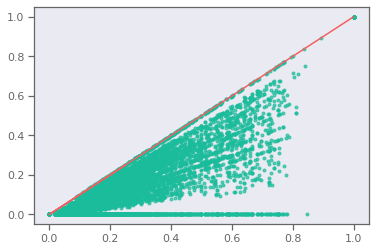

In [11]:
vanilla_df = cosine_similarity_base(vanilla_df, bases, llists)
vanilla_df["label_similarity"] = vanilla_df["similarity"] * vanilla_df["label_dot"]
plt.plot(vanilla_df["similarity"], vanilla_df["label_similarity"], ".", alpha=0.7)
plt.plot(vanilla_df["similarity"], vanilla_df["similarity"])
plt.show()

In [12]:
vanilla_df.to_csv("vanilla_samples_label_weighted_similarity.csv")
vanilla_samples = createExampleListfromDataFrame(vanilla_df)

#### Descriptor Explanation Plots

SMARTS annotations for MACCS descriptors were created using SMARTSviewer (smartsview.zbh.uni-hamburg.de, Copyright: ZBH, Center for Bioinformatics Hamburg) developed by K. Schomburg et. al. (J. Chem. Inf. Model. 2010, 50, 9, 1529–1535)


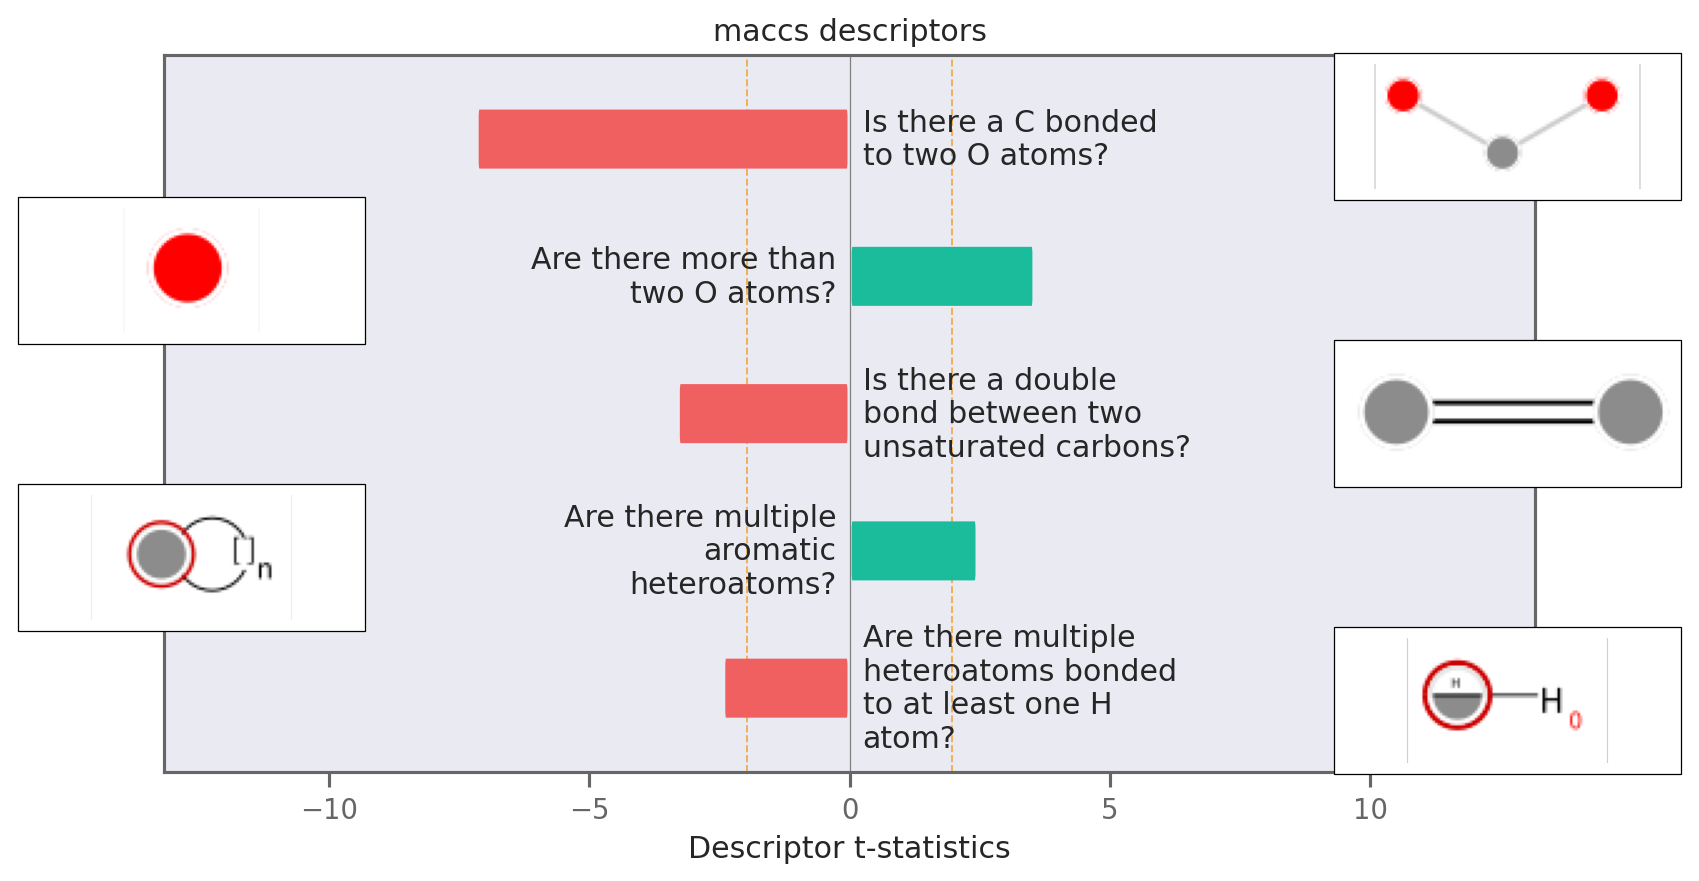

In [13]:
exmol.lime_explain(vanilla_samples, descriptor_type="MACCS")
exmol.plot_descriptors(vanilla_samples, output_file="vanilla_maccs.svg")

In [14]:
#vanilla_samples[1].descriptors

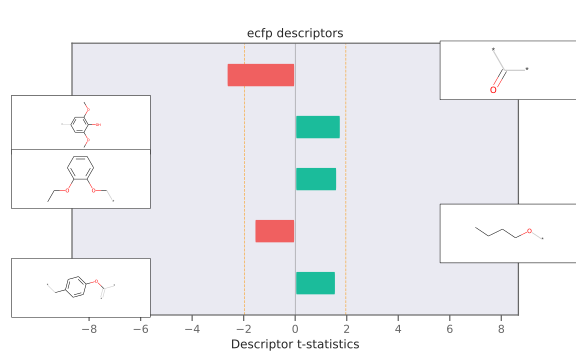

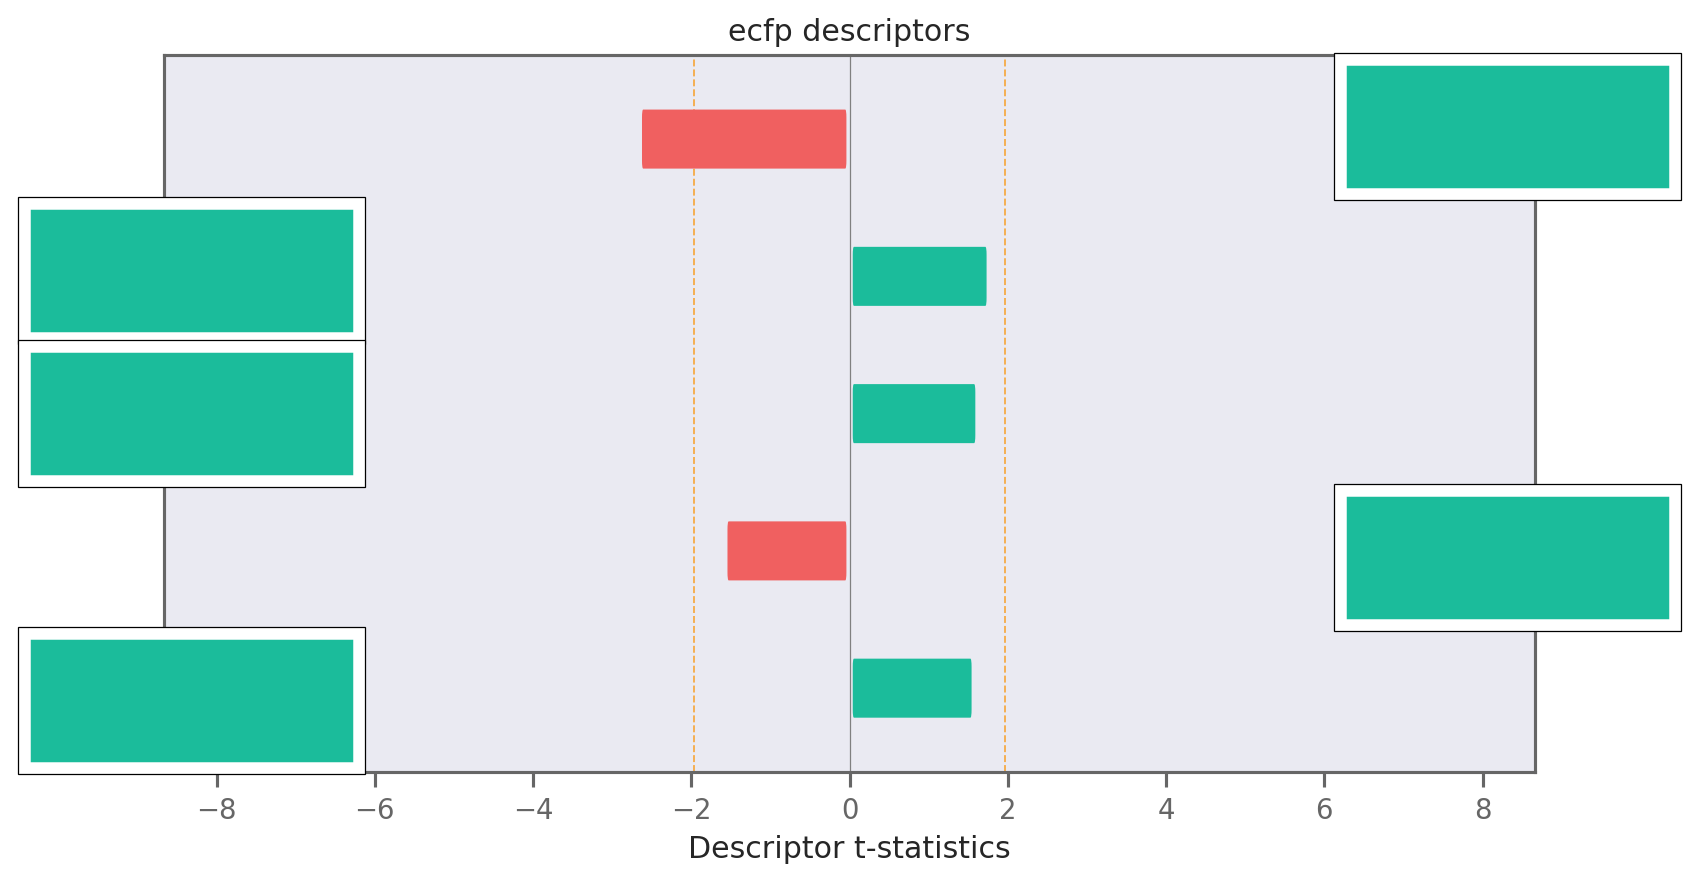

In [15]:
exmol.lime_explain(vanilla_samples, descriptor_type="ECFP")
svg = exmol.plot_descriptors(
    vanilla_samples, output_file="ecfp_vanilla_scent.svg", return_svg=True
)
from IPython.display import SVG, display

display(SVG(svg))

In [16]:
#vanilla_samples[0].descriptors

#### Natural language explanation prompts where lime_explain is called separately for maccs & ecfp descriptors and then the top k descriptors are given in the prompt (method 2)

In [17]:
print(exmol.text_explain2_maccs_and_ecfp(vanilla_samples))

Positive features:
Are there more than two O atoms? Yes. Important
Are there multiple aromatic heteroatoms? Yes. Important
Is there a CH2 group bonded to another atom and a heteroatom that is bonded to at least one H? Yes. Important
Alkylarylether Yes. Weakly Important
Is there an O with at least two chain bonds? Yes. Weakly Important
Alkylarylether Yes. Weakly Important
Is there more than one O atom? Yes. Weakly Important
Negative features:
Is there a C bonded to two O atoms? Yes. Very Important
Is there a double bond between two unsaturated carbons? Yes. Important
Are there multiple heteroatoms bonded to at least one H atom? Yes. Important



In [18]:
#try with different maximum number of descriptors in prompt
print(exmol.text_explain2_maccs_and_ecfp(vanilla_samples, num_descriptors = 5))
print(exmol.text_explain2_maccs_and_ecfp(vanilla_samples, num_descriptors = 8))

Positive features:
Are there more than two O atoms? Yes. Important
Are there multiple aromatic heteroatoms? Yes. Important
Negative features:
Is there a C bonded to two O atoms? Yes. Very Important
Is there a double bond between two unsaturated carbons? Yes. Important
Are there multiple heteroatoms bonded to at least one H atom? Yes. Important

Positive features:
Are there more than two O atoms? Yes. Important
Are there multiple aromatic heteroatoms? Yes. Important
Is there a CH2 group bonded to another atom and a heteroatom that is bonded to at least one H? Yes. Important
Alkylarylether Yes. Weakly Important
Is there an O with at least two chain bonds? Yes. Weakly Important
Negative features:
Is there a C bonded to two O atoms? Yes. Very Important
Is there a double bond between two unsaturated carbons? Yes. Important
Are there multiple heteroatoms bonded to at least one H atom? Yes. Important



#### Natural language explanation prompts where for the "combined" descriptor type, the lime_explain is called on a combination of maccs & ecfp descriptors (method 1)

In [19]:
exmol.lime_explain(vanilla_samples, descriptor_type="combined")

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -2.72147525e-01, -2.47901856e-10, -1.64077519e-10, -1.15936281e-01,
        2.87704565e-11,  1.28887631e-01,  4.36815912e-02, -2.74986510e-02,
       -2.32159698e-01,  7.95097670e-02, -3.77719796e-11, -1.19609794e-01,
       -4.32268383e-11, -1.14187155e-01,  7.72207409e-02,  1.15334993e-01,
        5.54271072e-03,  1.06085385e-11,  4.66636299e-02, -1.99447446e-10,
        4.63760836e-02,  4.48308406e-01, -3.71506690e-12,  1.17650835e-11,
       -4.03697894e-01, -1.70710675e-01, -1.50773555e-01, -1.64825405e-11,
        6.07793540e-01, -1.01690264e-11,  4.54001336e-01, -6.43754479e-12,
        2.21756708e-03, -5.75685935e-01,  7.73493557e-12, -6.68697239e-02,
       -5.42319033e-12, -4.19267651e-01,  8.56341739e-12,  4.45237880e-01,
        3.36019589e-13, -1.36831050e-01,  1.87796560e-01,  5.43585959e-01,
       -3.49609594e-01, -

In [20]:
prompt = (
    exmol.text_explain(vanilla_samples)
    + "Explanation: Molecules have vanilla smell because"
)
prompt

'Positive features:\nVinylogous ester Yes. Weakly Important\nIs there more than one O atom? Yes. Weakly Important\nIs there a double bond between two unsaturated carbons? Yes. Weakly Important\nIs there a tertiary C involved in a double bond? Yes. Weakly Important\nNegative features:\nPrimary alcohol Yes. Weakly Important\nExplanation: Molecules have vanilla smell because'

In [21]:
#vanilla_samples[0].descriptors

In [22]:
exmol.lime_explain(vanilla_samples, descriptor_type="ecfp")
prompt = (
    exmol.text_explain(vanilla_samples)
    + "Explanation: Molecules have vanilla smell because"
)
prompt

'Positive features:\nC Yes. Weakly Important\nO Yes. Weakly Important\nC Yes. Weakly Important\nNegative features:\nAldehyde Yes. Weakly Important\nO Yes. Weakly Important\nExplanation: Molecules have vanilla smell because'

#### Additional tests & code
(Includes code used to identify why 'alkyl aryl ether' was not appearing as a descriptor in the natural language explanations using exmol.text_explain with only 'ECFP' (not combined) and code to test exmol.text_explain2_maccs_and_ecfp() function/make sure all descriptors corresponded to a base molecule)

Vinylogous ester


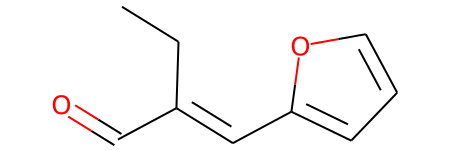

In [23]:
#Visualize first base molecule to see where 'Vinylogous ester' may be coming from (the 2nd & 3rd descriptors in the ECFP plot are 'aklyl aryl ether' not esters)
#Use code sent by Prof. White on slack for naming
def load_smarts(path):
    smarts = []
    with open(path) as f:
        for line in f.readlines():
            if line[0] == '#':
                continue
            i = line.find(':')            
            sm = line[i+1:].strip()            
            m = rdkit.Chem.MolFromSmarts(sm)
            smarts.append((line[:i].strip(), m))    
    return smarts[::-1]
smarts = load_smarts('/scratch/aseshad4/ScentPredictionNewSplits/OdorlessRemoved/SpaceGenerationAndExplanations/exmol/exmol/lime_data/smarts.txt')
def name(m, smarts=smarts):
    names = []
    for name, sm in smarts:
        match = m.GetSubstructMatches(sm)
        if match:
            names.append((len(match), name))
    names.sort()
    return names[-1][1].replace('_', ' ')

print(name(rdkit.Chem.MolFromSmiles('CC/C(C=O)=C\C1=CC=CO1')))
rdkit.Chem.MolFromSmiles('CC/C(C=O)=C\C1=CC=CO1')

In [24]:
#Noticed in exmol.py code for text explanation function, descriptors were only added to d_importance dictionary if examples[0].descriptors.descriptors[i] !=0
##Cells below test to see whether there is a case where examples[0].descriptors.descriptors[i] ==0 but for a different base molecule, it does not equal 0

In [25]:
#Code needed to name ECFP fingerprints with multiple bases (from exmol.py file)
_SMARTS = None

def _bit2atoms(m, bitInfo, key):
    # get atom id and radius
    i, r = bitInfo[key][0]  # just take first matching atom
    # taken from rdkit drawing code
    bitPath = rdkit.Chem.FindAtomEnvironmentOfRadiusN(m, r, i)

    # get the atoms for highlighting
    atoms = set((i,))
    for b in bitPath:
        atoms.add(m.GetBondWithIdx(b).GetBeginAtomIdx())
        atoms.add(m.GetBondWithIdx(b).GetEndAtomIdx())
    return atoms


def _load_smarts(path):
    smarts = []
    with open(path) as f:
        for line in f.readlines():
            if line[0] == "#":
                continue
            i = line.find(":")
            sm = line[i + 1 :].strip()
            m = rdkit.Chem.MolFromSmarts(sm)
            smarts.append((line[:i].strip(), m))
    return smarts[::-1]


def _name_morgan_bit(m, bitInfo, key):
    global _SMARTS
    if _SMARTS is None:
        from importlib_resources import files  # type: ignore
        import exmol.lime_data  # type: ignore

        sp = files(exmol.lime_data).joinpath("smarts.txt")
        _SMARTS = _load_smarts(sp)
    morgan_atoms = _bit2atoms(m, bitInfo, key)
    if len(morgan_atoms) == 1:
        # only 1 atom, just return element
        return m.GetAtomWithIdx(list(morgan_atoms)[0]).GetSymbol()
    names = []
    for name, sm in _SMARTS:
        matches = m.GetSubstructMatches(sm)
        for match in matches:
            # check if match is in morgan bit
            match = set(match)
            if match.issubset(morgan_atoms):
                names.append((len(match), name))
    names.sort()
    if len(names) == 0:
        return None
    return names[-1][1].replace("_", " ")

In [26]:
#Test showing example where vanilla_samples[0].descriptors.descriptors[pos] == 0 
## but that descriptor is present in one of the other base molecules (just not the first)

base_mol = [exmol.smi2mol(e.smiles) for e in vanilla_samples if e.is_origin == True]
bi = {}  # type: Dict[Any, Any]
for b in base_mol:
    bit_info = {}  # type: Dict[Any, Any]
    fp = AllChem.GetMorganFingerprint(b, 3, bitInfo=bit_info)
    for bit in bit_info:
        if bit not in bi:
            bi[bit] = (b, bit, bit_info)
            
#Example where vanilla_samples[0].descriptors.descriptors[pos] == 0 but that descriptor is present in one of the base molecules
pos = vanilla_samples[0].descriptors.descriptor_names.index(616584597)
base_molecules = [e for e in vanilla_samples if e.is_origin == True]
base_molecules_descriptor_values =  [base_mol.descriptors.descriptors[pos] for base_mol in base_molecules]
print(np.count_nonzero(base_molecules_descriptor_values))
print(vanilla_samples[0].descriptors.descriptors[pos])
k = vanilla_samples[0].descriptors.descriptor_names[pos]
m = bi[int(k)][0]
b = bi[int(k)][2]
name = _name_morgan_bit(m, b, k)
print(f'Name corresponding to key {k}: {name}')



3
0
Name corresponding to key 616584597: Alkylarylether


In [27]:
#Check that descriptors in d_importance (see exmol.py text_explain functions) are all found in the base molecules (there is at least 1 base molecule with that descriptor)

#Code below copied from text_explain2 function in exmol.py file for this test
#First get results for MACCS descriptors
exmol.lime_explain(vanilla_samples, descriptor_type='maccs')
tstats_maccs = list(vanilla_samples[0].descriptors.tstats)

# Take t-statistics, rank them
d_importance_maccs = {
    a: [b, i]
    for i, a, b in zip(
        np.arange(len(vanilla_samples[0].descriptors.descriptors)),
        vanilla_samples[0].descriptors.descriptor_names,
        tstats_maccs,
    )
    if not np.isnan(b) and vanilla_samples[0].descriptors.descriptors[i] != 0
}

base_molecules = [e for e in vanilla_samples if e.is_origin == True]
for i, (k, v) in enumerate(d_importance_maccs.items()):
    pos = vanilla_samples[0].descriptors.descriptor_names.index(k)
    base_molecules_descriptor_values =  [base_mol.descriptors.descriptors[pos] for base_mol in base_molecules]
    if(np.count_nonzero(base_molecules_descriptor_values) == 0): #Found a MACCS descriptor not in the base molecules
        print(k)

#Then test for ECFP descriptors
exmol.lime_explain(vanilla_samples, descriptor_type='ecfp')
tstats_ecfp = list(vanilla_samples[0].descriptors.tstats)

# Take t-statistics, rank them
d_importance_ecfp = {
    a: [b, i]
    for i, a, b in zip(
        np.arange(len(vanilla_samples[0].descriptors.descriptors)),
        vanilla_samples[0].descriptors.descriptor_names,
        tstats_ecfp,
    )
    if not np.isnan(b) and vanilla_samples[0].descriptors.descriptors[i] != 0
}

base_molecules = [e for e in vanilla_samples if e.is_origin == True]
for i, (k, v) in enumerate(d_importance_ecfp.items()):
    pos = vanilla_samples[0].descriptors.descriptor_names.index(k)
    base_molecules_descriptor_values =  [base_mol.descriptors.descriptors[pos] for base_mol in base_molecules]
    if(np.count_nonzero(base_molecules_descriptor_values) == 0): #Found an ecfp descriptor not in base molecules
        print(k)

